In [82]:
import numpy as np
import pandas as pd
import gc
import pickle
import os
import datetime as dt

#plot
import matplotlib.pyplot as plt

#LightGBM
import lightgbm as lgb

#sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

#表示桁数の指定
pd.options.display.float_format = '{:.4f}'.format

In [83]:
#train.csvファイルの読み込み
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(750000, 12)


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.8100,Thursday,Night,NaN,0.0000,Positive,31.4200
1,1,Joke Junction,Episode 26,119.8000,Comedy,66.9500,Saturday,Afternoon,75.9500,2.0000,Negative,88.0124
2,2,Study Sessions,Episode 16,73.9000,Education,69.9700,Tuesday,Evening,8.9700,0.0000,Negative,44.9253
3,3,Digital Digest,Episode 45,67.1700,Technology,57.2200,Monday,Morning,78.7000,2.0000,Positive,46.2782
4,4,Mind & Body,Episode 86,110.5100,Health,80.0700,Monday,Afternoon,58.6800,3.0000,Neutral,75.6103


In [84]:
#メモリ削減の為の関数
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [85]:
#データセット作成
train 
x_train = train.drop(columns=["id", "Listening_Time_minutes","Genre","Episode_Length_minutes"])
y_train = train["Listening_Time_minutes"]
id_train = train[["id"]]

In [86]:
#カテゴリ変数をcatgory型に変換
for col in x_train.columns:
    if x_train[col].dtype == "object":
        x_train[col] = x_train[col].astype("category")

In [87]:
#trainの情報を確認
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


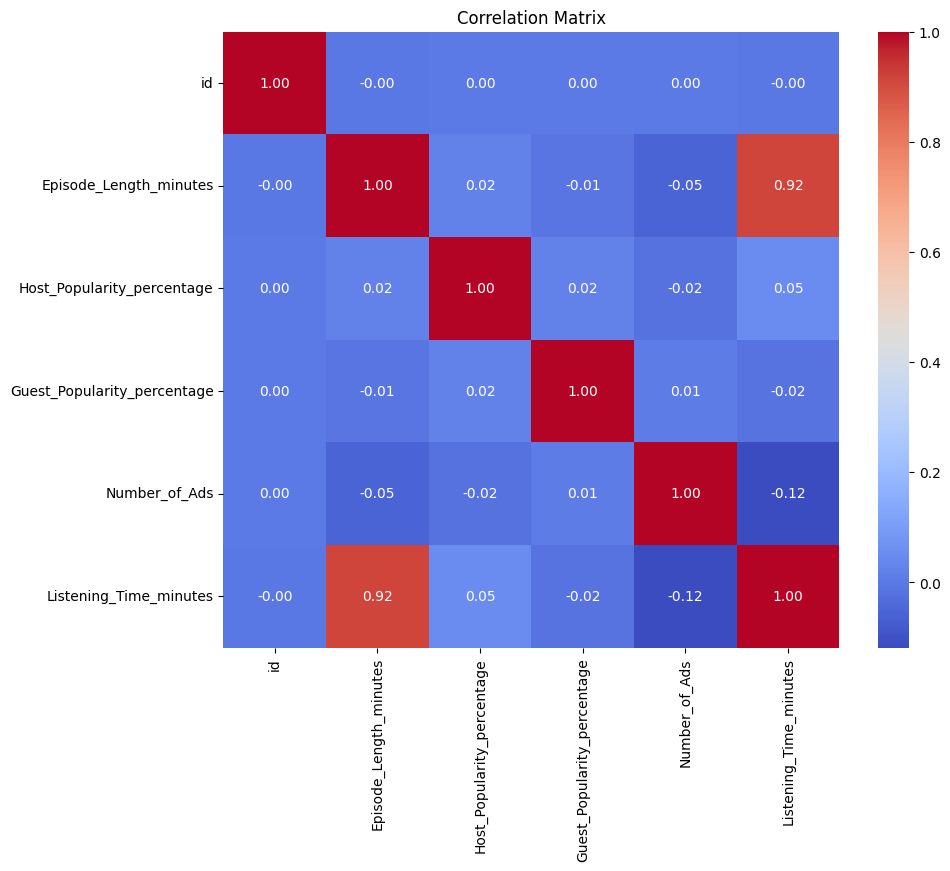

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# 相関係数の計算
corr = train.corr(numeric_only=True)

# ヒートマップの描画
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()


In [89]:
import os
import joblib
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def train_lgb_regression(input_x,
                         input_y,
                         input_id,
                         params,
                         list_nfold=[0,1,2,3,4],
                         n_splits=5,
                         save_dir="models"):
    train_oof = np.zeros(len(input_x))
    metrics = []
    imp = pd.DataFrame()

    os.makedirs(save_dir, exist_ok=True)

    # クロスバリデーション（回帰はKFoldでOK）
    cv = list(KFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x))
    
    for nfold in list_nfold:
        print("-" * 20, f"Fold {nfold}", "-" * 20)
        
        idx_tr, idx_va = cv[nfold]
        x_tr, y_tr, id_tr = input_x.loc[idx_tr, :], input_y[idx_tr], input_id.loc[idx_tr, :]
        x_va, y_va, id_va = input_x.loc[idx_va, :], input_y[idx_va], input_id.loc[idx_va, :]
        print(f"Train shape: {x_tr.shape}, Validation shape: {x_va.shape}")
        
        # モデル学習（Regressorに変更）
        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_tr, y_tr,
            eval_set=[(x_tr, y_tr), (x_va, y_va)],
            early_stopping_rounds=100,
            verbose=100
        )
        
        fname_lgb = os.path.join(save_dir, f"model_lgb_fold{nfold}.joblib")
        joblib.dump(model, fname_lgb)
        
        # 回帰なので predict() を使う
        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)
        
        # 評価指標はRMSE
        metric_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
        metric_va = np.sqrt(mean_squared_error(y_va, y_va_pred))
        metrics.append([nfold, metric_tr, metric_va])
        print(f"[RMSE] Train: {metric_tr:.4f}, Validation: {metric_va:.4f}")
        
        train_oof[idx_va] = y_va_pred
        
        _imp = pd.DataFrame({"col": input_x.columns, "imp": model.feature_importances_, "nfold": nfold})
        imp = pd.concat([imp, _imp])
      
    print("-" * 20, "Training Results", "-" * 20)
    
    metrics = np.array(metrics)
    print("[CV] Train RMSE: {:.4f}±{:.4f}, Validation RMSE: {:.4f}±{:.4f}".format(
        metrics[:, 1].mean(), metrics[:, 1].std(),
        metrics[:, 2].mean(), metrics[:, 2].std(),
    ))
    print("[OOF RMSE] {:.4f}".format(np.sqrt(mean_squared_error(input_y, train_oof))))
    
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({"pred": train_oof})
    ], axis=1)
    
    imp = imp.groupby("col")["imp"].agg(["mean", "std"]).reset_index()
    imp.columns = ["col", "imp", "imp_std"]
    
    print("Training completed. Models saved to:", save_dir)
    
    return train_oof, imp, metrics


In [90]:
# ハイパーパラメータの設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

# 学習の実行
train_oof, imp, metrics = train_lgb_regression(x_train,
                                    y_train,
                                    id_train,
                                    params,
                                    list_nfold=[0,1,2,3,4],
                                    n_splits=5,
                                   )

-------------------- Fold 0 --------------------
Train shape: (600000, 8), Validation shape: (150000, 8)
[100]	training's auc: 0.909554	valid_1's auc: 0.850513
[200]	training's auc: 0.947267	valid_1's auc: 0.85337
[300]	training's auc: 0.964187	valid_1's auc: 0.85299
[RMSE] Train: 52.0794, Validation: 52.0629
-------------------- Fold 1 --------------------
Train shape: (600000, 8), Validation shape: (150000, 8)
[100]	training's auc: 0.914981	valid_1's auc: 0.838779
[200]	training's auc: 0.950204	valid_1's auc: 0.841726
[RMSE] Train: 52.0629, Validation: 52.1295
-------------------- Fold 2 --------------------
Train shape: (600000, 8), Validation shape: (150000, 8)
[100]	training's auc: 0.912978	valid_1's auc: 0.848692
[200]	training's auc: 0.948269	valid_1's auc: 0.849448
[RMSE] Train: 52.0808, Validation: 52.0586
-------------------- Fold 3 --------------------
Train shape: (600000, 8), Validation shape: (150000, 8)
[100]	training's auc: 0.909844	valid_1's auc: 0.85272
[200]	training

In [91]:
imp.sort_values("imp", ascending=False)[:10]
#特徴量の重要度を可視化

,col,imp,imp_std
1,Episode_Title,83533.9476,5328.2222
2,Guest_Popularity_percentage,70558.2878,2806.3441
3,Host_Popularity_percentage,57447.6320,2691.4262
5,Podcast_Name,40038.2618,3979.4988
0,Episode_Sentiment,27285.7122,987.4119
4,Number_of_Ads,14566.7569,732.4922
7,Publication_Time,7136.9940,440.8131
6,Publication_Day,4041.4884,590.3441


In [92]:
#テーブルデータの形の確認
train.shape

(750000, 12)

In [93]:
#欠損値の確認
train.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [94]:
#重複行の確認
train.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
749995    False
749996    False
749997    False
749998    False
749999    False
Length: 750000, dtype: bool

In [95]:
#要約特徴量の一括確認(数値型)
train.describe()


,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.0000,662907.0000,750000.0000,603970.0000,749999.0000,750000.0000
mean,374999.5000,64.5047,59.8599,52.2364,1.3489,45.4374
std,216506.4953,32.9696,22.8731,28.4512,1.1511,27.1383
min,0.0000,0.0000,1.3000,0.0000,0.0000,0.0000
25%,187499.7500,35.7300,39.4100,28.3800,0.0000,23.1783
50%,374999.5000,63.8400,60.0500,53.5800,1.0000,43.3795
75%,562499.2500,94.0700,79.5300,76.6000,2.0000,64.8116
max,749999.0000,325.2400,119.4600,119.9100,103.9100,119.9700


In [96]:
#要約特徴量の一括確認(カテゴリ変数)
train.describe(include="object")

,Podcast_Name,Episode_Title,Genre,Publication_Day,Publication_Time,Episode_Sentiment
count,750000,750000,750000,750000,750000,750000
unique,48,100,10,7,4,3
top,Tech Talks,Episode 71,Sports,Sunday,Night,Neutral
freq,22847,10515,87606,115946,196849,251291


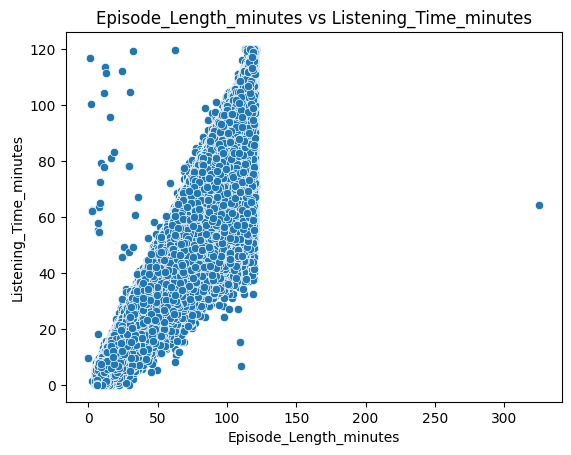

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# 例：x軸 = 'age'（年齢）、y軸 = 'income'（収入）
sns.scatterplot(x='Episode_Length_minutes', y='Listening_Time_minutes', data=train)
plt.title("Episode_Length_minutes vs Listening_Time_minutes")
plt.show()


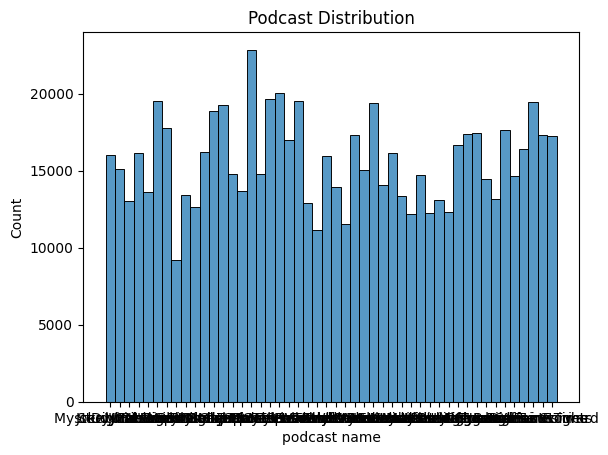

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# 例：'age' という特徴量の分布をヒストグラムで表示
sns.histplot(train['Podcast_Name'], kde=False, bins=20)
plt.title("Podcast Distribution")
plt.xlabel("podcast name")
plt.ylabel("Count")
plt.show()


In [99]:
# 'Podcast_name' のユニークな値と出現回数を降順で表示
print(train['Podcast_Name'].value_counts())


Podcast_Name
Tech Talks             22847
Sports Weekly          20053
Funny Folks            19635
Tech Trends            19549
Fitness First          19488
Business Insights      19480
Style Guide            19364
Game Day               19272
Melody Mix             18889
Criminal Minds         17735
Finance Focus          17628
Detective Diaries      17452
Crime Chronicles       17374
Athlete's Arena        17327
Fashion Forward        17280
Tune Time              17254
Business Briefs        17012
Lifestyle Lounge       16661
True Crime Stories     16373
Sports Central         16191
Digital Digest         16171
Humor Hub              16144
Mystery Matters        16002
Comedy Corner          15927
Joke Junction          15074
Wellness Wave          15009
Sport Spot             14778
Gadget Geek            14770
Home & Living          14686
Laugh Line             14673
Life Lessons           14464
World Watch            14043
Sound Waves            13928
Global News            13649
M

In [100]:
# 'Episode_Title' のユニークな値と出現回数を降順で表示
print(train['Episode_Title'].value_counts())


Episode_Title
Episode 71    10515
Episode 62    10373
Episode 31    10292
Episode 61     9991
Episode 69     9864
              ...  
Episode 2      5134
Episode 25     5117
Episode 41     4965
Episode 37     4940
Episode 95     4838
Name: count, Length: 100, dtype: int64


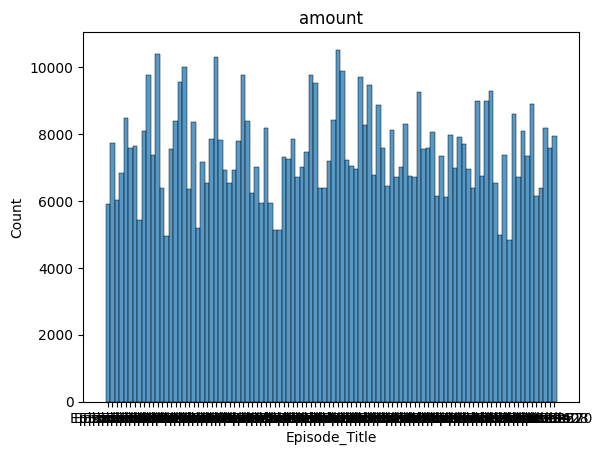

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# 例：'Episode_Title' という特徴量の分布をヒストグラムで表示
sns.histplot(train['Episode_Title'], kde=False, bins=20)
plt.title("amount")
plt.xlabel("Episode_Title")
plt.ylabel("Count")
plt.show()


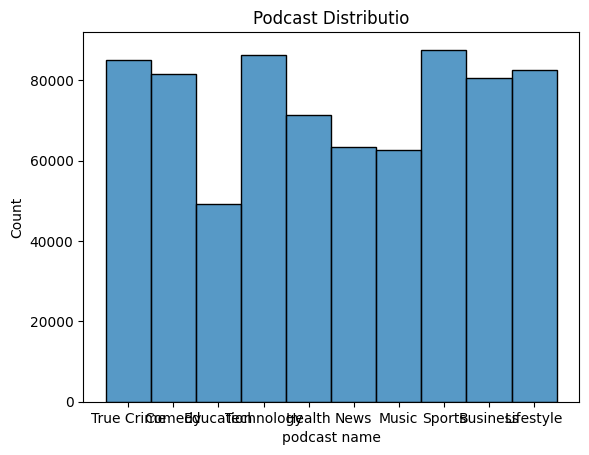

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

# 例：'Genre' という特徴量の分布をヒストグラムで表示
sns.histplot(train['Genre'], kde=False, bins=20)
plt.title("Podcast Distributio")
plt.xlabel("podcast name")
plt.ylabel("Count")
plt.show()


In [103]:
from ydata_profiling import ProfileReport 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [105]:
# 例：'Genre' と 'Podcase_Name' の関係をクロス集計
pd.crosstab(train['Genre'], train['Podcast_Name'])


Podcast_Name,Athlete's Arena,Brain Boost,Business Briefs,Business Insights,Comedy Corner,Crime Chronicles,Criminal Minds,Current Affairs,Daily Digest,Detective Diaries,...,Sports Central,Sports Weekly,Study Sessions,Style Guide,Tech Talks,Tech Trends,True Crime Stories,Tune Time,Wellness Wave,World Watch
Genre,,,,,,,,,,,,,,,,,,,,,
Business,4,0,17004,19471,0,1,4,6,2,1,...,0,0,7,3,5,0,0,3,1,5
Comedy,21,5,2,1,15924,1,4,8,5,4,...,0,1,2,4,6,1,0,17,5,8
Education,9,11504,0,1,0,3,7,0,0,3,...,0,1,13006,1,6,1,2,1,4,3
Health,5,5,1,0,0,4,1,2,4,0,...,0,0,15,6,1,0,1,5,14967,4
Lifestyle,3,1,0,1,1,12,6,1,4,18,...,1,0,5,19305,1,2,4,4,4,4
Music,5,6,0,0,1,4,3,6,1,0,...,2,0,6,14,4,1,1,17199,5,3
News,11,3,0,3,1,5,7,13086,13357,3,...,1,0,2,8,5,4,2,2,3,13997
Sports,17256,2,2,1,0,5,5,9,12,2,...,16185,20048,6,6,1,2,2,9,5,6
Technology,5,14,3,0,0,3,1,3,2,4,...,2,1,3,7,22815,19534,0,10,0,3


In [106]:
# 各Podcastに対するGenreの割合を行方向で正規化
cross_tab_percentage = pd.crosstab(train['Podcast_Name'], train['Genre'], normalize='index').T
print(cross_tab_percentage)


Podcast_Name  Athlete's Arena  Brain Boost  Business Briefs  \
Genre                                                         
Business               0.0002       0.0000           0.9995   
Comedy                 0.0012       0.0004           0.0001   
Education              0.0005       0.9966           0.0000   
Health                 0.0003       0.0004           0.0001   
Lifestyle              0.0002       0.0001           0.0000   
Music                  0.0003       0.0005           0.0000   
News                   0.0006       0.0003           0.0000   
Sports                 0.9959       0.0002           0.0001   
Technology             0.0003       0.0012           0.0002   
True Crime             0.0005       0.0003           0.0000   

Podcast_Name  Business Insights  Comedy Corner  Crime Chronicles  \
Genre                                                              
Business                 0.9995         0.0000            0.0001   
Comedy                   0.0001        

In [107]:
import statsmodels.api as sm

# カテゴリ変数をダミー変数に変換
X = pd.get_dummies(train['Genre'], drop_first=True)  # drop_first=True で基準カテゴリーを削除
y = train['Listening_Time_minutes']

# 定数項を追加
X = sm.add_constant(X)

# 線形回帰モデルを適合
model = sm.OLS(y, X).fit()

# 回帰結果を表示
print(model.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).